In [122]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
from onehotencoder import OneHotEncoder_int
import os
import pandas as pd

In [123]:
featurevars = ['H_mass', 'H_pt', 'Z_pt', 'Z_eta', 'Z_phi', 'gamma_pt', 'gamma_eta', 'gamma_phi', 'gamma_mvaID', 'n_jets', 'n_leptons', 'regions']
rootfile_target='./datasets/data.root'
rootfile_source='./datasets/ZGToLLG.root'

def prepdata(filename):
    hzg = uproot.open(filename)
    hzgtree = hzg['passedEvents']
    iscategorical = [False, False, False, False, False, False, False, False, False, False, False, True]
    _onehotencoder = OneHotEncoder_int(iscategorical)

    arrays = hzgtree.arrays(featurevars, library="pd")
    inputtmp = pd.DataFrame(arrays)

    inputnumpy = inputtmp.to_numpy(dtype=np.float32)
    inputs = _onehotencoder.encode(inputnumpy)
    ncats = _onehotencoder.ncats
    ncat_per_feature = _onehotencoder.categories_per_feature

    meanslist = []
    sigmalist = []
    currentcolumn = 0
    for ifeat, ncatfeat in zip(range(inputtmp.shape[1]), ncat_per_feature):
        if ncatfeat == 0: # fir float features, get mean and sigma
            mean = np.mean(inputnumpy[:, currentcolumn], axis=0, dtype=np.float32).reshape(1,1)
            meanslist.append(mean)
            sigma = np.std(inputnumpy[:, currentcolumn], axis=0, dtype=np.float32).reshape(1,1)
            sigmalist.append(sigma)
            currentcolumn += 1
        else: # categorical features do not get changed
            mean = np.zeros(shape=(1, ncatfeat), dtype=np.float32) 
            meanslist.append(mean)
            sigma = np.ones(shape=(1, ncatfeat), dtype=np.float32)
            sigmalist.append(sigma)
            currentcolumn += ncatfeat

    inputmeans = np.hstack(meanslist)
    inputsigma = np.hstack(sigmalist)

    normedinputs = (inputs-inputmeans) / inputsigma

    return inputtmp, normedinputs, inputmeans, inputsigma, ncat_per_feature

In [124]:
rawinputs_target, normedinputs_target, inputmeans_target, inputsigma_target, ncat_per_feature_target = prepdata(rootfile_target)
rawinputs_source, normedinputs_source, inputmeans_source, inputsigma_source, ncat_per_feature_source = prepdata(rootfile_source)
print(ncat_per_feature_target)
inputdim = 11
ncat_per_feature_target = ncat_per_feature_target[0:inputdim]
conddim = normedinputs_target.shape[1] - inputdim

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]


In [125]:
issignal_target = (rawinputs_target['regions']==0) # signal_selection 
issignal_source = (rawinputs_source['regions']==0) # signal_selection 
isbackground_target = ~issignal_target
isbackground_source = ~issignal_source
bkgnormed_target = normedinputs_target[isbackground_target]
bkgnormed_source = normedinputs_source[isbackground_source]
bkg_target = rawinputs_target[isbackground_target]
bkg_source = rawinputs_source[isbackground_source]   
#xmax = np.reshape(inputmeans + 5* inputsigma, inputmeans.shape[1])


In [126]:
bkgnormed_target[0,11:]

array([0., 1., 0., 0.], dtype=float32)

In [127]:
from ABCD_dnn_mmd import ABCDdnn

LRrange3 = [0.00001, 0.00001, 20000, 0]

nafdim=128
depth=2
batchsize=512
seed=101

m = ABCDdnn(ncat_per_feature_target, inputdim, minibatch=batchsize, conddim=conddim, LRrange=LRrange3, \
        beta1=0.9, beta2=0.999, nafdim=nafdim, depth=depth, savedir='abcdnn_HZG', retrain=False, seed=seed)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_25 (Sl (None, 11)           0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor_4 (TFOpLam (None, 11)           0           tf.__operators__.getitem_25[0][0]
__________________________________________________________________________________________________
tf.compat.v1.gather_4 (TFOpLamb (None, 11)           0           tf.convert_to_tensor_4[0][0]     
____________________________________________________________________________________________

In [128]:
m.setrealdata(bkgnormed_target, bkgnormed_source)
m.savehyperparameters()
m.monitorevery = 100

1000 1.597e-01 
1100 1.587e-01 
1200 3.636e-01 
1300 1.008e-01 
1400 9.081e-02 
1500 9.237e-02 
1600 5.761e-02 
1700 5.248e-02 
1800 4.607e-02 
1900 4.040e-02 


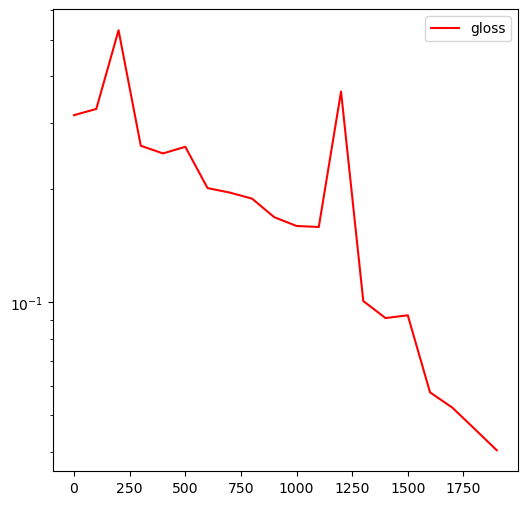

In [129]:
steps = 1000
m.train(steps)
m.display_training()

In [24]:
ncol=4 # for plots below
condlist = {
            "SR": [[1., 0., 0., 0., ]],
            "CR1": [[0., 1., 0., 0., ]],
            "CR2": [[0., 0., 1., 0., ]],
            "CR3": [[0., 0., 0., 1., ]]
            }

select_data_target = {
    "SR": (rawinputs_target['regions']==0),
    "CR1": (rawinputs_target['regions']==1),
    "CR2": (rawinputs_target['regions']==2),
    "CR3": (rawinputs_target['regions']==3)
}

select_data_source = {
    "SR": (rawinputs_source['regions']==0),
    "CR1": (rawinputs_source['regions']==1),
    "CR2": (rawinputs_source['regions']==2),
    "CR3": (rawinputs_source['regions']==3)
}

select_data_source_transfered = {}

plottextlist=['SR','CR1','CR2','CR3']



In [69]:

#xin = normedinputs_source[select_data_source["CR2"]][0:1]
#print(cond_to_append, xin, condlist["CR2"])
#print(xin)
#m.model.predict(xin)

#minibatch = batchsize

for r in plottextlist:
    select_data_source_transfered[r] = []

    transferedlist = []

    xin = normedinputs_source[select_data_source[r]]
    xgen = m.model.predict(xin)
    transferedlist.append(xgen)
    
    transfered_data= np.vstack(transferedlist)
    transfered_data = transfered_data * inputsigma_source[:, :inputdim] + inputmeans_source[:, :inputdim]
    ntransfered_data = transfered_data.shape[0]
    print(ntransfered_data)

    select_data_source_transfered[r].append(transfered_data)


[[ 0.3315339   1.0123137   0.31148756 -0.38334256 -1.4817733   0.021652
  -1.3271388   1.1879388   0.3017501   3.7006927  -0.08134023  0.
   0.          1.          0.        ]]
682302
203901
15246
44346


In [88]:
#select_data_source_transfered["CR3"][0][:,0]

array([[139.51347   ,  22.850288  ,  32.78974   , ...,   0.61947894,
          0.19848095,   2.005067  ],
       [127.075455  ,  15.505886  ,  31.015236  , ...,   0.51895934,
          0.17641848,   2.0059958 ],
       [129.48047   ,  24.459053  ,  32.51507   , ...,   0.6638769 ,
          0.7190572 ,   2.0037162 ],
       ...,
       [144.14302   ,  38.70797   ,  36.598293  , ...,   0.31865874,
          0.7378402 ,   2.0015812 ],
       [128.20842   ,  22.328857  ,  30.518433  , ...,   0.63720286,
          0.18640393,   2.0069761 ],
       [156.18857   ,  17.374573  ,  36.540318  , ...,   0.6453424 ,
          0.17981297,   2.005583  ]], dtype=float32)

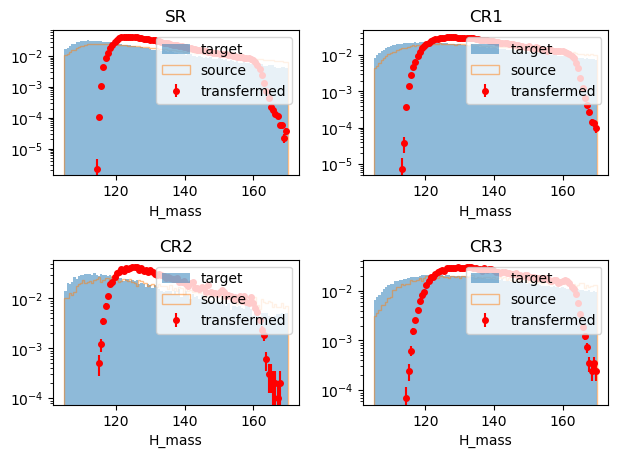

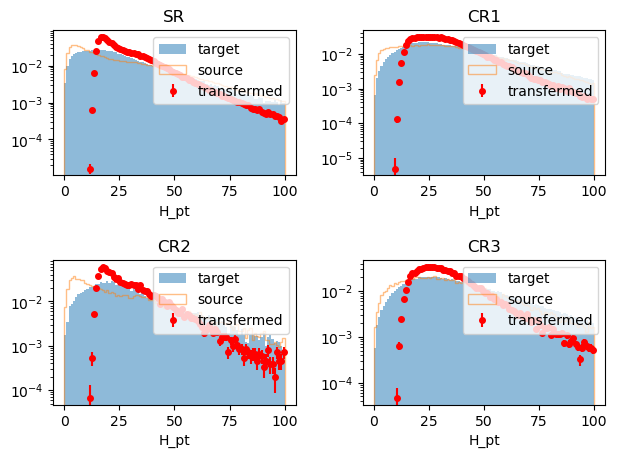

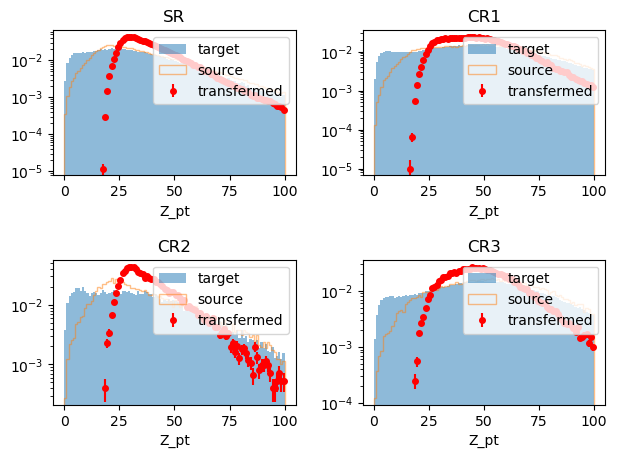

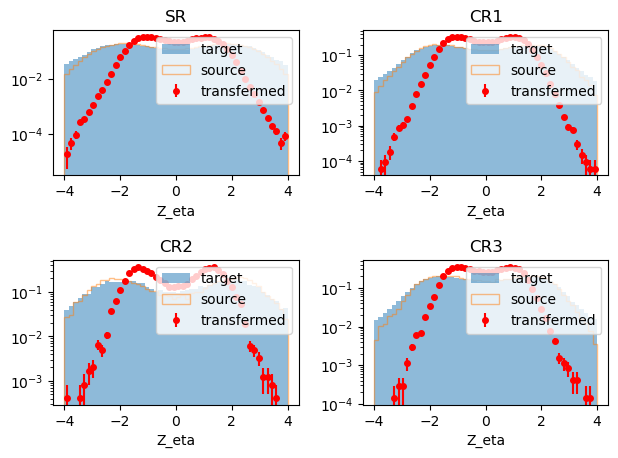

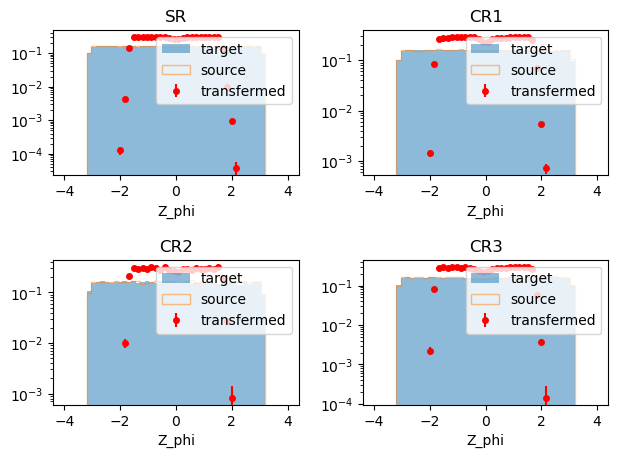

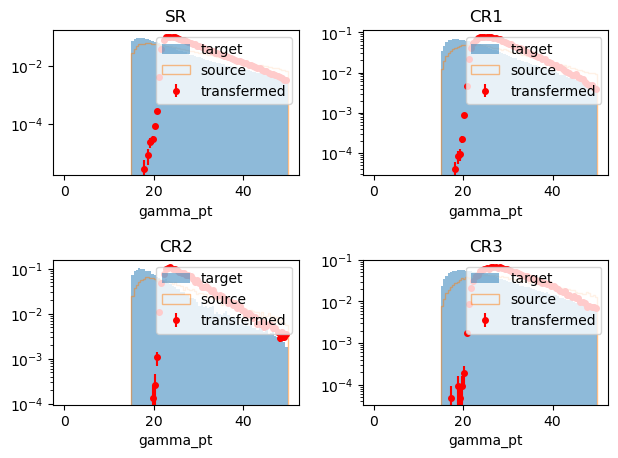

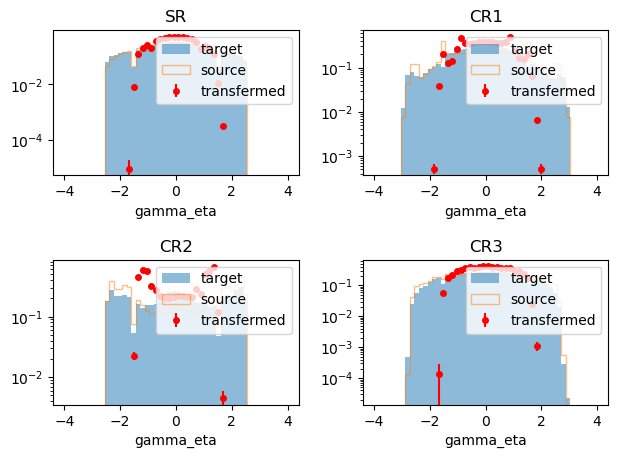

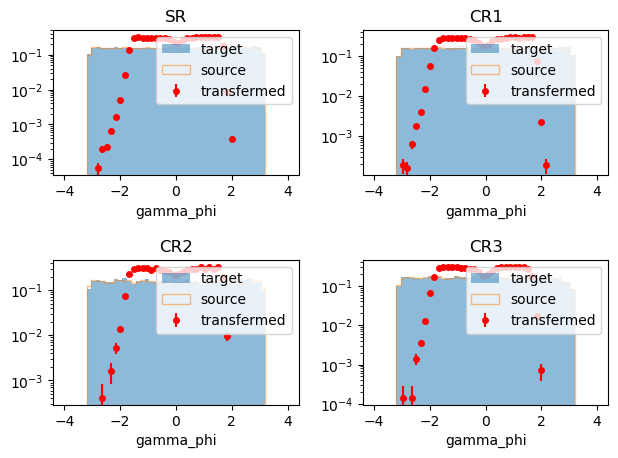

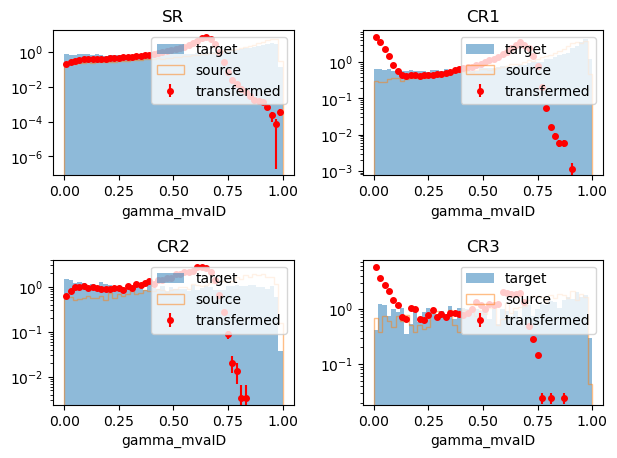

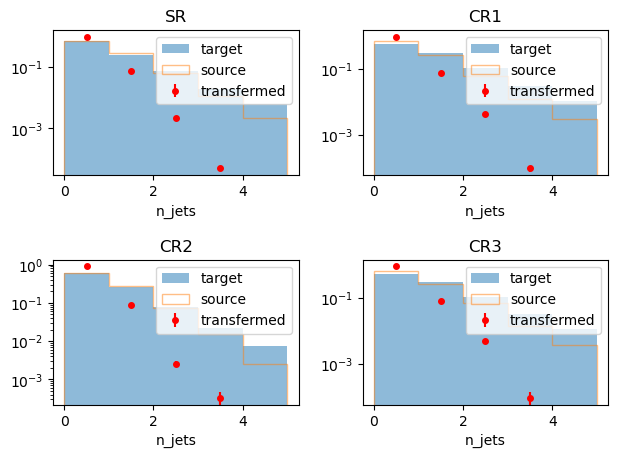

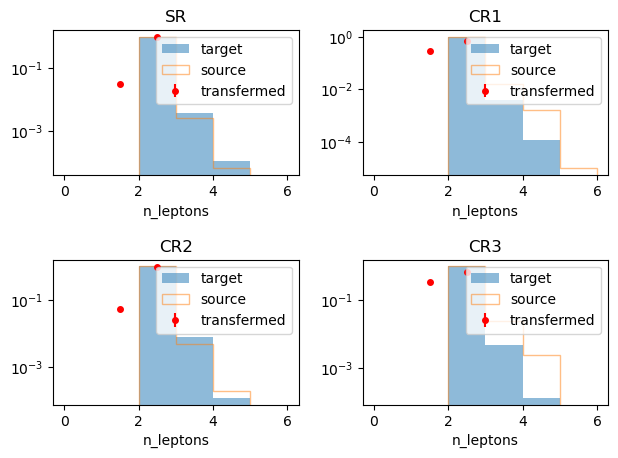

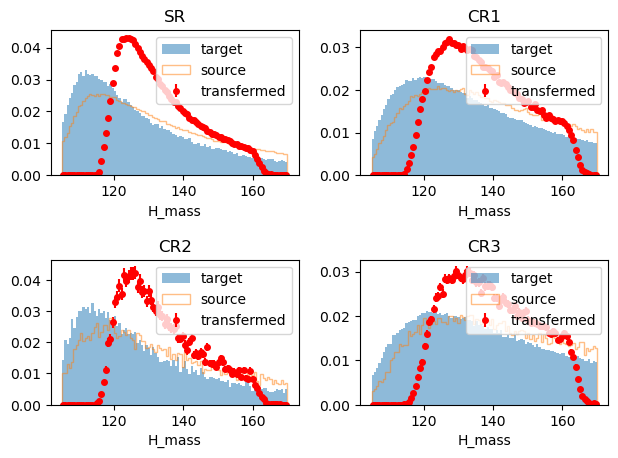

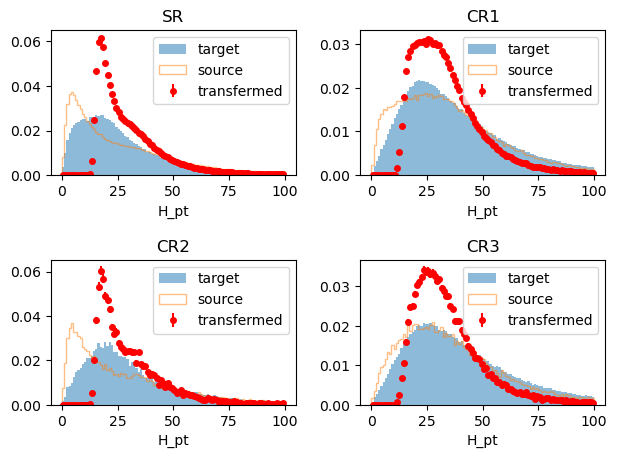

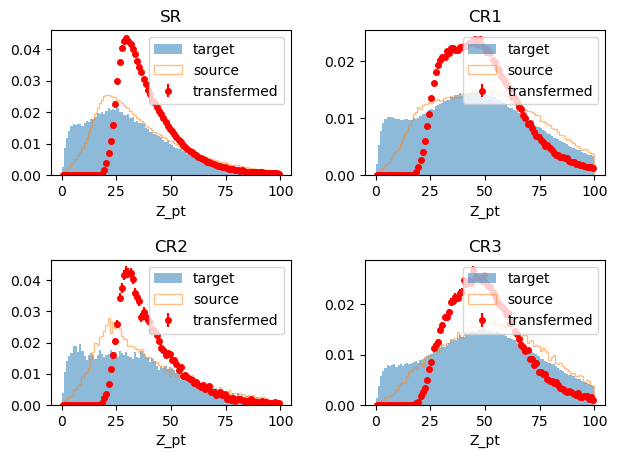

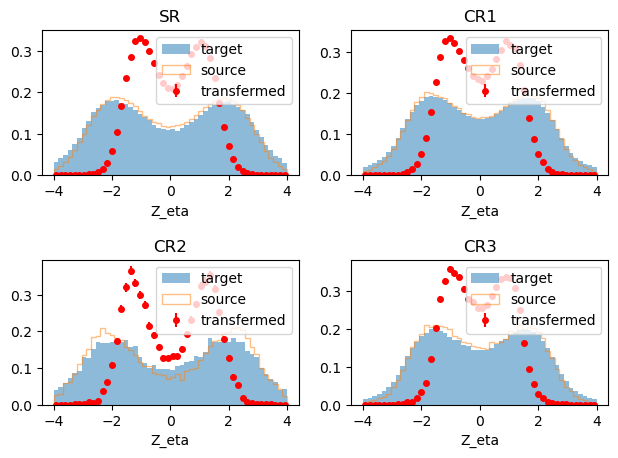

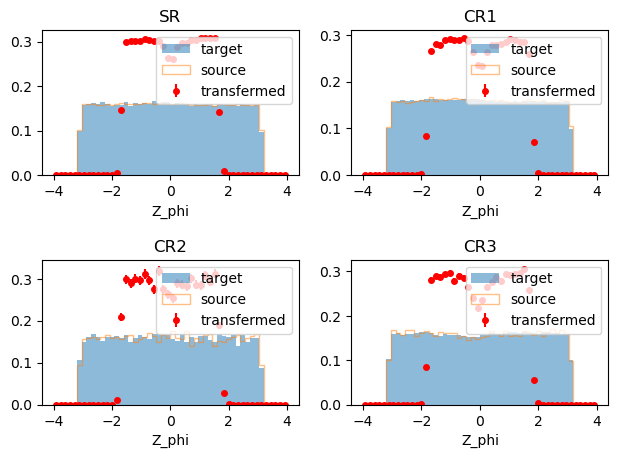

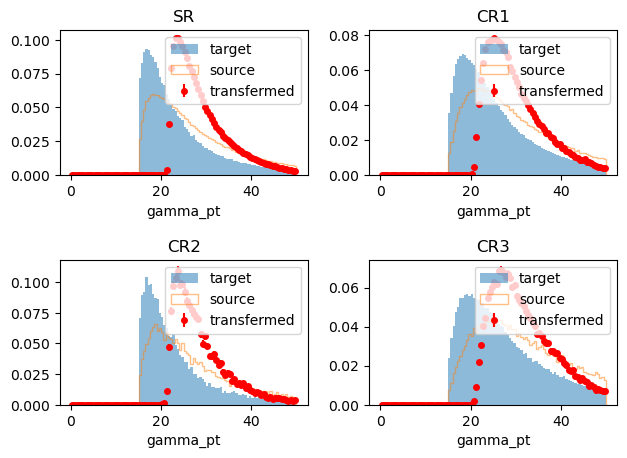

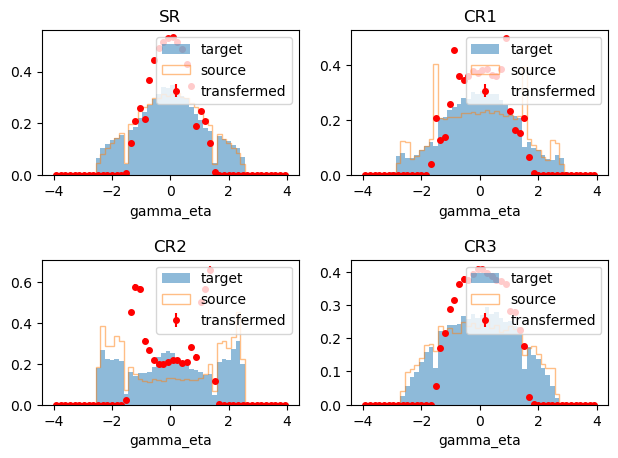

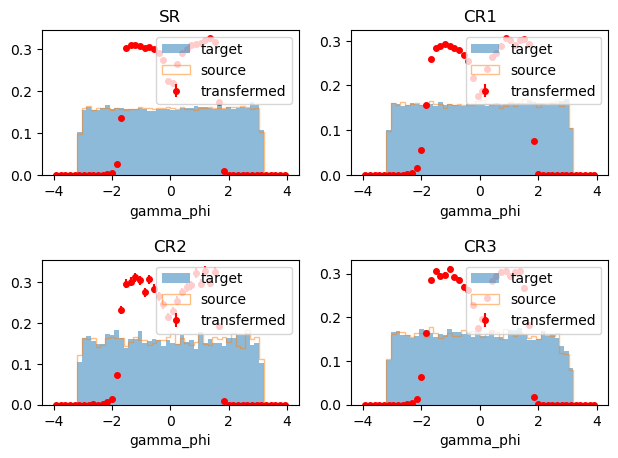

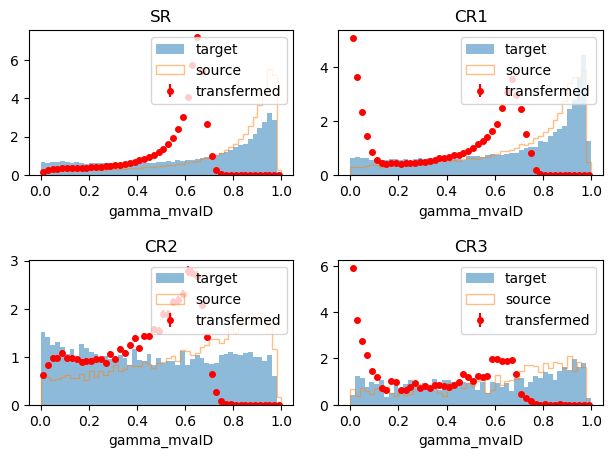

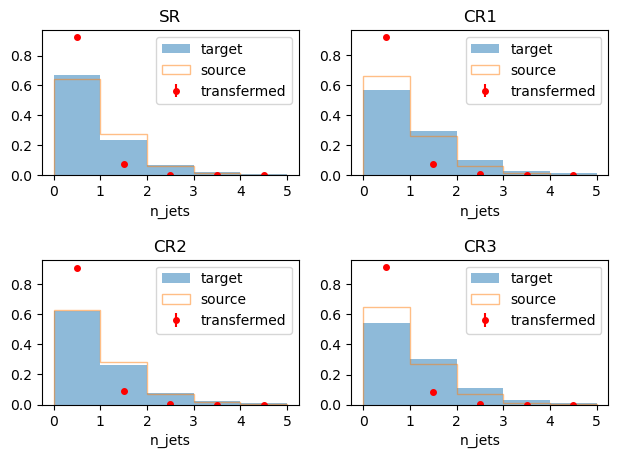

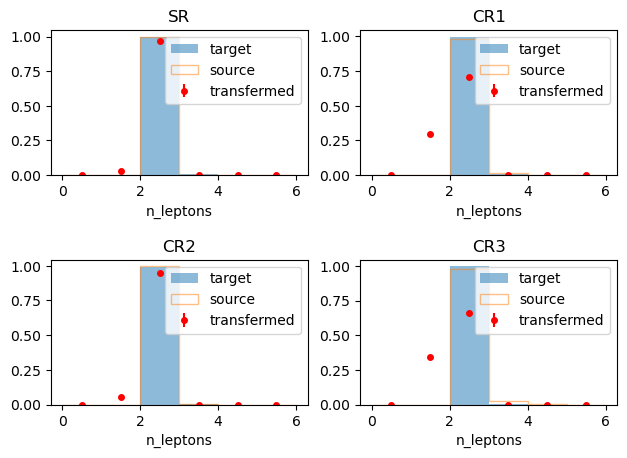

In [121]:
labelsindices = [['H_mass', 'H_mass', 105., 170, 100], 
                 ['H_pt', 'H_pt', 0.0, 100., 100],
                 ['Z_pt', 'Z_pt', 0.0, 100., 100], 
                 ['Z_eta', 'Z_eta', -4., 4., 50],
                 ['Z_phi', 'Z_phi', -4., 4., 50],
                 ['gamma_pt', 'gamma_pt', 0., 50., 100],
                 ['gamma_eta', 'gamma_eta', -4., 4., 50],
                 ['gamma_phi', 'gamma_phi', -4., 4., 50],
                 ['gamma_mvaID', 'gamma_mvaID', 0.,1., 50],
                 ['n_jets', 'n_jets', 0., 5., 5],
                 ['n_leptons', 'n_leptons', 0., 6., 6]]
runplots = True

if runplots:
    yscales = ['log', 'linear']
    for yscale in yscales:
        for li in labelsindices:
            pos = featurevars.index(li[1])
            nbins = li[-1]
            
            for r in plottextlist:
                #print(rawinputs_target[select_data_target[r]])
                target_data = rawinputs_target[select_data_target[r]]
                source_data = rawinputs_source[select_data_source[r]]
                source_transfered_data = select_data_source_transfered[r][0]

                #plt.figure(figsize=(6, 3))
                plt.subplot(2, 2, plottextlist.index(r)+1)
                #ax[row,col].set_xlabel(f"${li[0]}$")
                plt.hist(target_data[li[1]], bins=nbins, alpha=0.5, range=(li[2], li[3]), histtype='bar', density=True, label='target')
    
                hist1, bins = np.histogram(source_transfered_data[:,pos],bins=nbins, range=(li[2], li[3]), density=True)
                scale = len(source_transfered_data[:,pos]) / sum(hist1)
                err = np.sqrt(hist1 * scale) / scale
                center = (bins[:-1] + bins[1:]) / 2
                plt.errorbar(center, hist1, yerr=err, fmt='.', c='r', markersize=8,capthick=0, label='transfermed')

                plt.hist(source_data[li[1]], bins=nbins, alpha=0.5, range=(li[2], li[3]), histtype='step', density=True, label='source')
                plt.yscale(yscale)
                plt.title(r)
                plt.xlabel(li[1])
                plt.legend(loc="upper right")
                #plt.text(0.6, 0.8, r, transform=ax[row,col].transAxes, fontsize=10)
                
            plt.tight_layout(pad=1.5)
            plt.show()
            #fig.tight_layout()
            #fig.savefig(os.path.join(savedir, f'result_matrix_{li[1]}_{yscale}.pdf'))

In [1]:
import HZGammaAna

2024-01-02 20:55:42.202517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-02 20:55:42.202547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]


2024-01-02 20:57:45.527944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-02 20:57:45.528235: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-02 20:57:45.528252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lxplus810.cern.ch): /proc/driver/nvidia/version does not exist
2024-01-02 20:57:45.528479: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 11)           0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 11)           0           tf.__operators__.getitem_1[0][0] 
__________________________________________________________________________________________________
tf.compat.v1.gather (TFOpLambda (None, 11)           0           tf.convert_to_tensor[0][0]       
______________________________________________________________________________________________

2024-01-02 20:57:53.379476: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


0 3.148e-01 
100 3.270e-01 


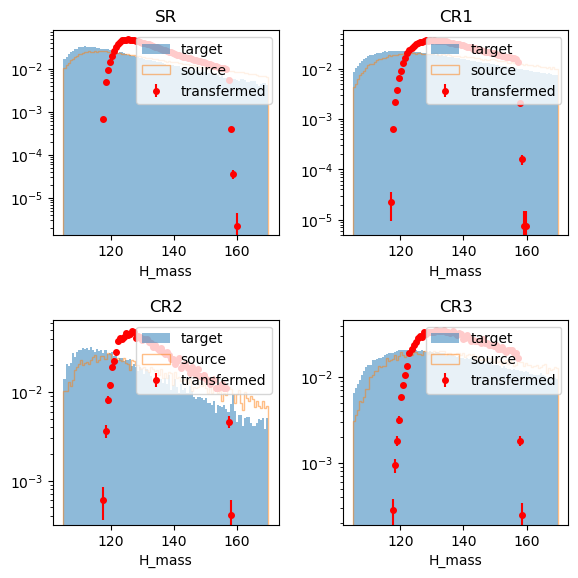

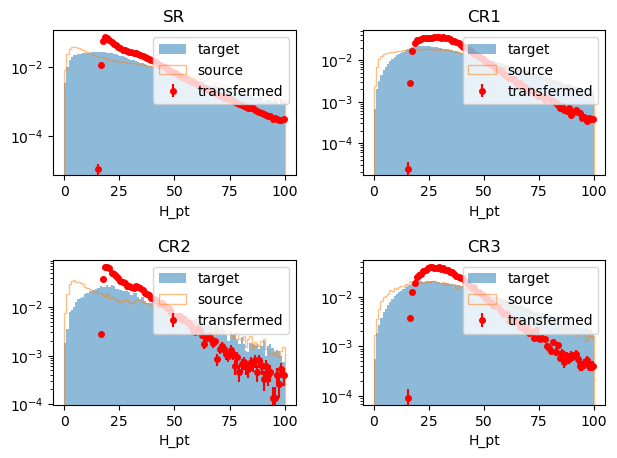

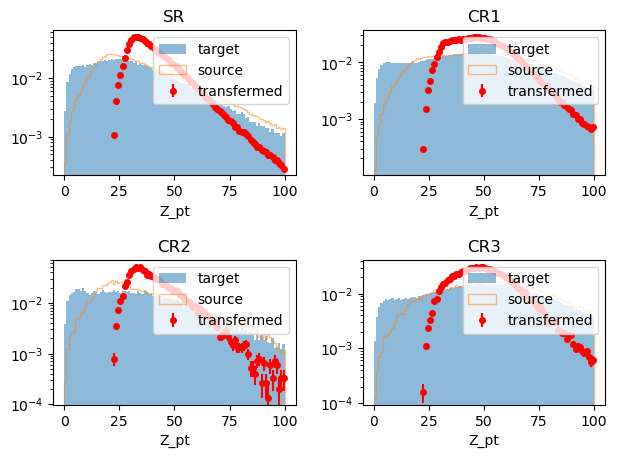

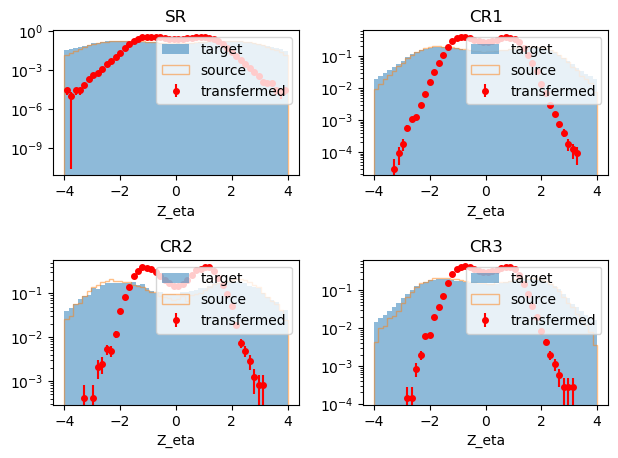

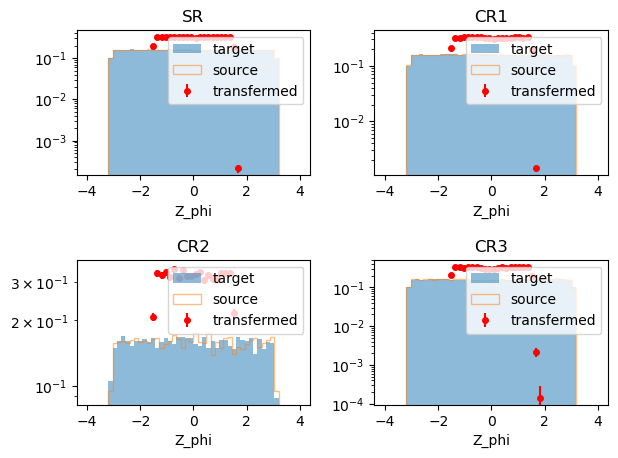

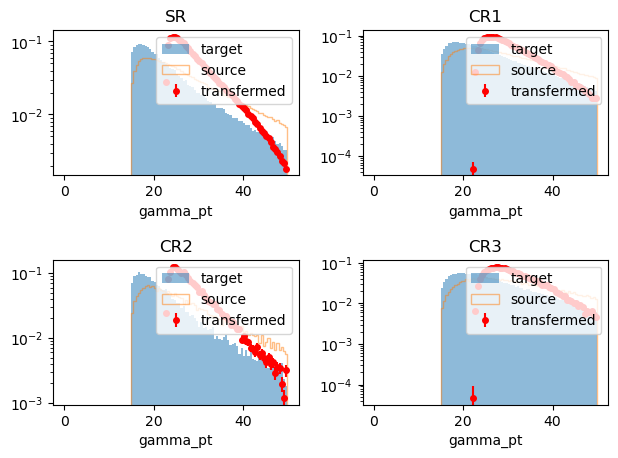

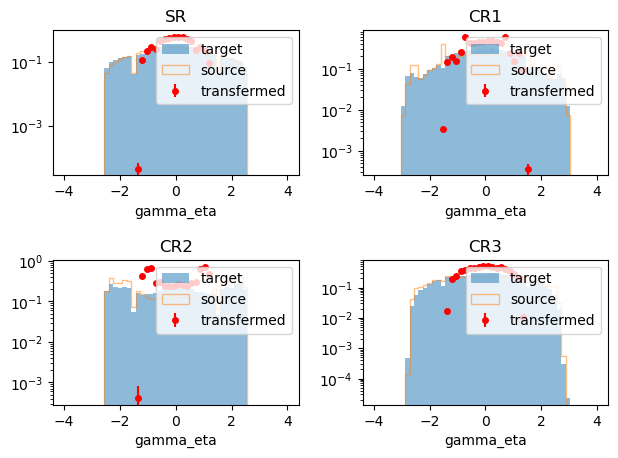

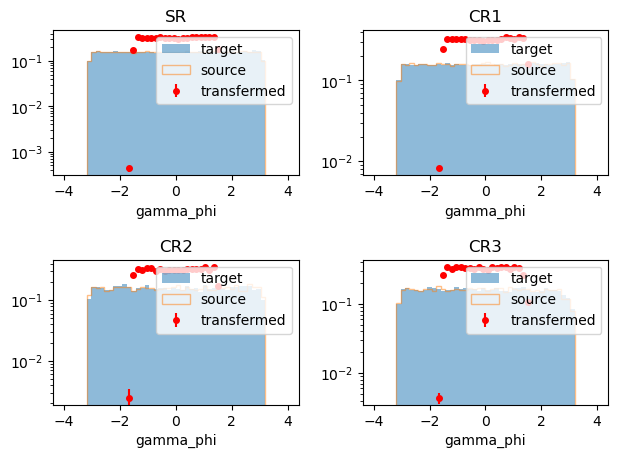

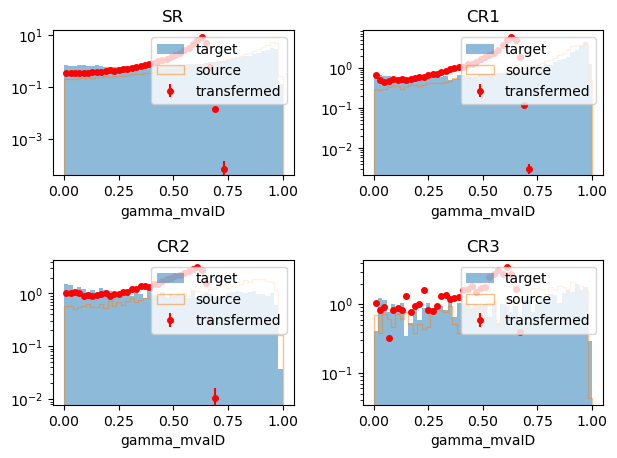

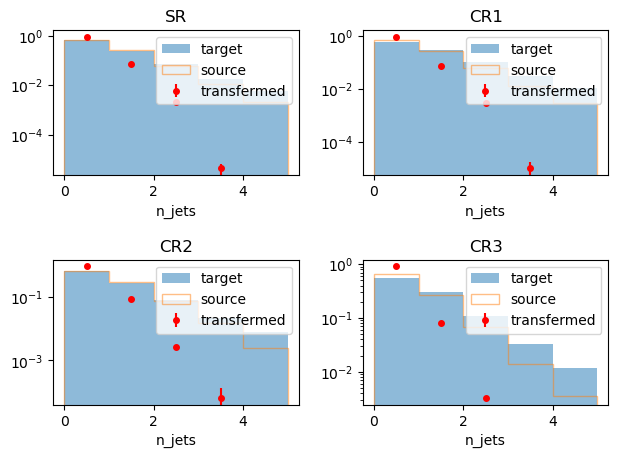

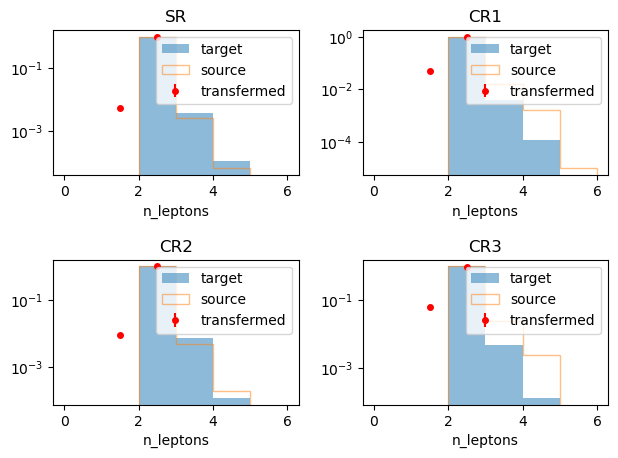

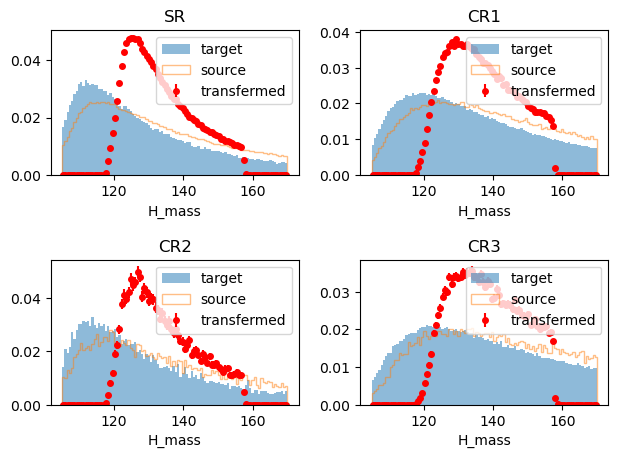

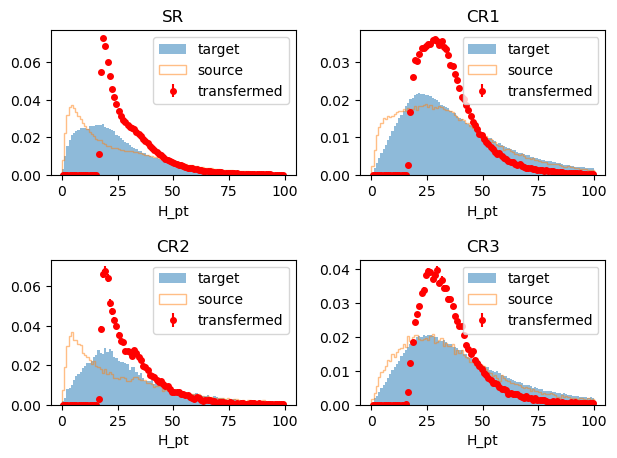

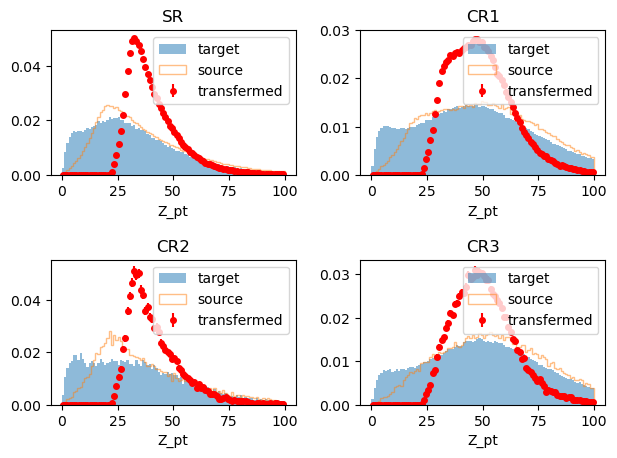

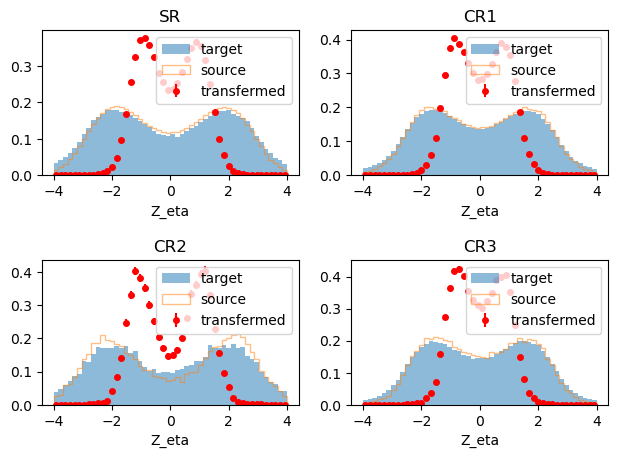

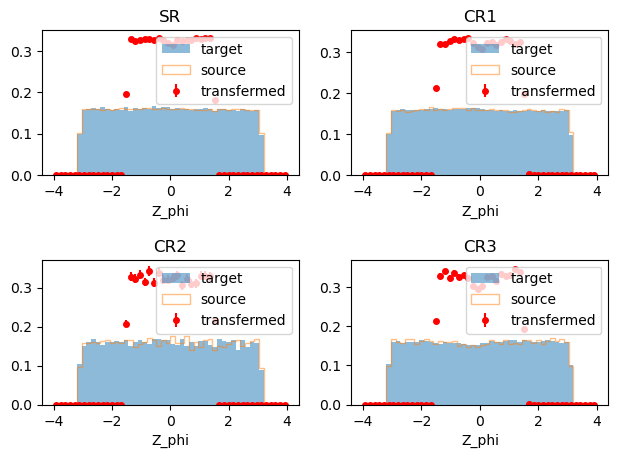

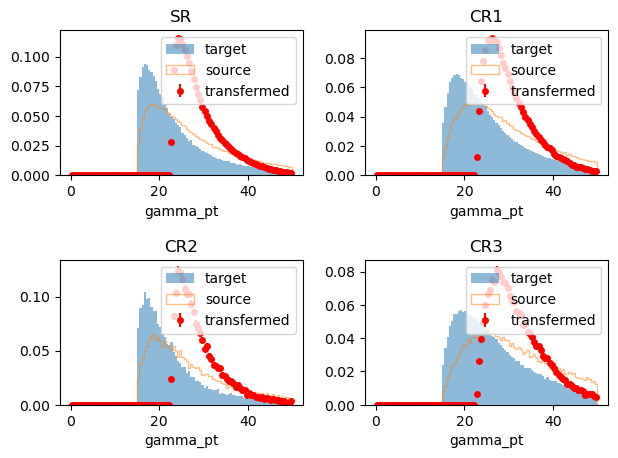

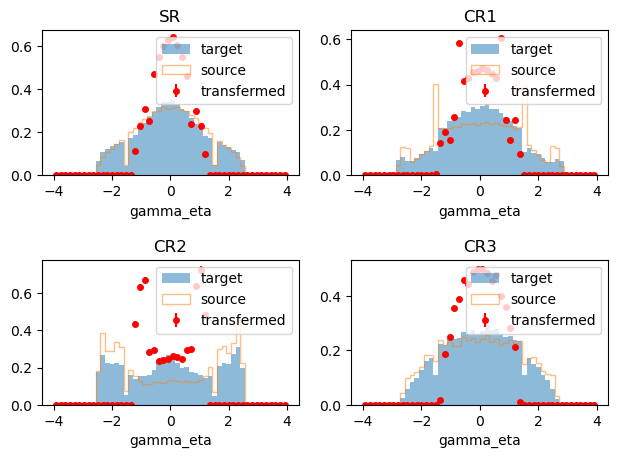

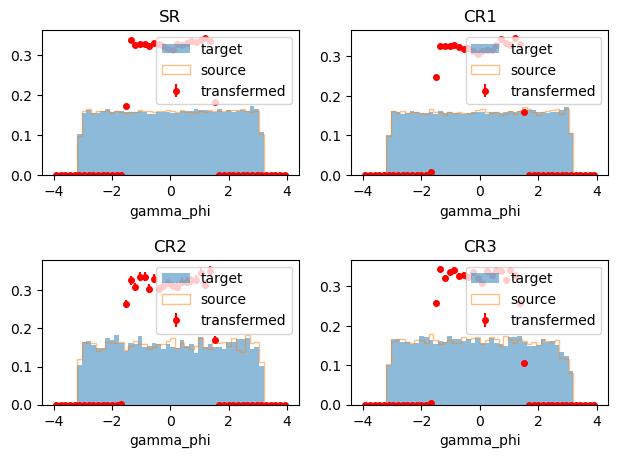

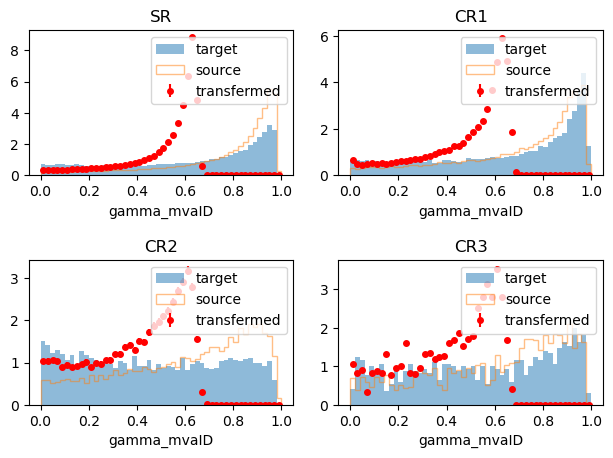

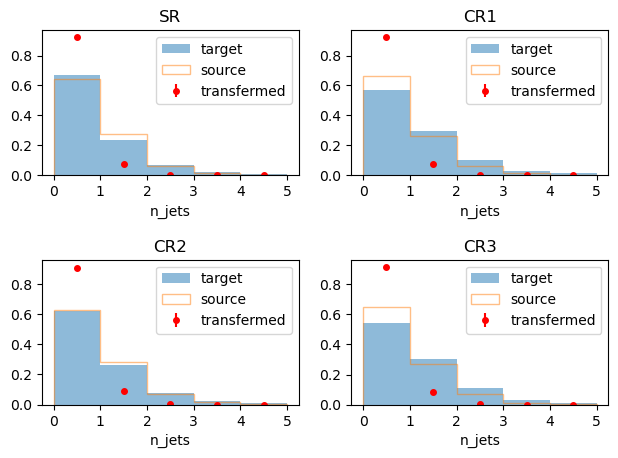

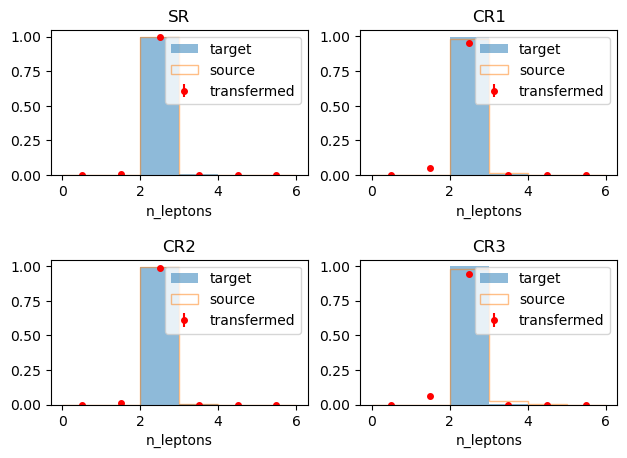

<Figure size 640x480 with 0 Axes>

In [2]:
LRrange3 = [0.00001, 0.00001, 20000, 0]

nafdim=128
depth=2
batchsize=512
seed=101

HZGammaAna.train_and_validate(steps=200, LRrange=LRrange3, minibatch=batchsize, beta1=0.9, beta2=0.999, \
    savedir=f'hzg_nafnodropout{nafdim}_{batchsize}_depth{depth}_{seed}_9_3_LR3mmd/', nafdim=nafdim, depth=depth, seed=seed, retrain=False, train=True)
